<a href="https://www.kaggle.com/code/shantyn/google-analytics-sample?scriptVersionId=205333779" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Google Analytics Sample
The Google Analytics Sample is a tabular dataset containing records of user activity for visitors to the Google Merchandise Store from 1st August 2016, to 1st August 2017. This dataset is publicly available in BigQuery.
# Goal
To create queries and visualizations for both daily data and interval data, and to derive insights from them.     

First we'll examine the data schema and review its contents.

In [1]:
%%capture
! pip install statsforecast datasetsforecast
! pip install git+https://github.com/Nixtla/neuralforecast.git@main
! pip install -U ipywidgets

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.dates as mdates
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import bq_helper
from bq_helper import BigQueryHelper
from google.cloud import bigquery
from neuralforecast import NeuralForecast
from neuralforecast.auto import NHITS, BiTCN
from neuralforecast.losses.pytorch import DistributionLoss
from utilsforecast.preprocessing import fill_gaps
from statsforecast import StatsForecast

In [3]:
def print_schema(schema, indent=0):
    indent_ = "-" * indent
    for field in schema:
        print(indent_, field.name, field.field_type, field.mode, '\n')
        if field.description:
            print(indent_,field.description)
        if field.field_type == 'RECORD':
            print(indent_+'- '+'subfields:\n')
            print_schema(field.fields, indent= indent+1)

In [4]:
def line_bar_monthly(date,y_bar,y_line,bar_label,line_label,title):
    fig = go.Figure()

    fig.add_trace(
        go.Bar(
            x=date,
            y=y_bar,
            name=bar_label,
            marker_color='skyblue',
            yaxis="y1" 
        )
    )

    fig.add_trace(
        go.Scatter(
            x=date,
            y=y_line,
            name=line_label,
            mode='lines+markers',
            marker=dict(color='green'),
            yaxis="y2"  
        )
    )

    fig.update_layout(
        title_text=title,
        xaxis=dict(title='Date', tickformat="%b %Y"), 
        yaxis=dict(
            title=bar_label,
            titlefont=dict(color='skyblue'),
            tickfont=dict(color='skyblue')
        ),
        yaxis2=dict(
            title=line_label,
            titlefont=dict(color='green'),
            tickfont=dict(color='green'),
            overlaying='y', 
            side='right'  
        ),
        barmode='group',
        hovermode='x unified' 
    )

    fig.show()

In [5]:
def histogram(data, x_title, y_title, title):
    fig = go.Figure()
    fig.add_trace(go.Histogram(
        x=data,
        marker=dict(color='skyblue'),
        opacity=0.75,
        name='Data',
        hovertemplate=f"{x_title}: %{{x}}<br>{y_title}: %{{y}}"
    ))

    fig.update_layout(
        title=title,
        xaxis_title=x_title,
        yaxis_title=y_title,
        template='plotly_white'
    )

    # Show plot
    fig.show()

In [6]:
def grouped_bar(x,y1,y2,y1_label,y2_label,title):
    fig = go.Figure()

    fig.add_trace(
        go.Bar(
            x=x,
            y=y1,
            name=y1_label,
            marker_color='skyblue',
            offsetgroup=1,  
            yaxis='y1',
            hovertemplate=f"{x.name}: %{{x}}<br>{y1_label}: %{{y}}"
        )
    )

    fig.add_trace(
        go.Bar(
            x=x,
            y=y2,
            name=y2_label,
            marker_color='green',
            offsetgroup=2, 
            yaxis='y2',
            hovertemplate=f"{x.name}: %{{x}}<br>{y2_label}: %{{y}}"
        )
    )

    fig.update_layout(
        title=title,
        xaxis=dict(title='Browser'),
        yaxis=dict(
            title=y1_label,
            titlefont=dict(color='skyblue'),
            tickfont=dict(color='skyblue')
        ),
        yaxis2=dict(
            title=y2_label,
            titlefont=dict(color='green'),
            tickfont=dict(color='green'),
            anchor="free", 
            overlaying='y', 
            side='right', 
            position=1  
        ),
        barmode='group'
    )

    fig.show()

In [7]:
def barh_plot(df, category_column_name, numeric_column_name, title):
    df_sorted = df.sort_values(by=numeric_column_name)
    
    fig = go.Figure(go.Bar(
        x=df_sorted[numeric_column_name],
        y=df_sorted[category_column_name],
        orientation='h',
        text=df_sorted[numeric_column_name],  
        textposition='outside' ,
        name= 'Data',
        hovertemplate=f"{numeric_column_name}: %{{x}}<br>{category_column_name}: %{{y}}"
    ))

    fig.update_layout(
        title=title,
        xaxis_title=numeric_column_name,
        yaxis_title=category_column_name,
        bargap=0.1, 
        template='plotly_white',
    )

    fig.show()

# 1. Examine the available dates in the dataset.  
Each table have the format ga_sessions_YYYYMMDD. This indicates that each table contains data for a specific date: YYYYMMDD.

In [8]:
google_analytics = bq_helper.BigQueryHelper(active_project="bigquery-public-data",
                                   dataset_name="data:google_analytics_sample")
bq_assistant = BigQueryHelper("bigquery-public-data", "google_analytics_sample")
bq_assistant.list_tables()

Using Kaggle's public dataset BigQuery integration.
Using Kaggle's public dataset BigQuery integration.


['ga_sessions_20160801',
 'ga_sessions_20160802',
 'ga_sessions_20160803',
 'ga_sessions_20160804',
 'ga_sessions_20160805',
 'ga_sessions_20160806',
 'ga_sessions_20160807',
 'ga_sessions_20160808',
 'ga_sessions_20160809',
 'ga_sessions_20160810',
 'ga_sessions_20160811',
 'ga_sessions_20160812',
 'ga_sessions_20160813',
 'ga_sessions_20160814',
 'ga_sessions_20160815',
 'ga_sessions_20160816',
 'ga_sessions_20160817',
 'ga_sessions_20160818',
 'ga_sessions_20160819',
 'ga_sessions_20160820',
 'ga_sessions_20160821',
 'ga_sessions_20160822',
 'ga_sessions_20160823',
 'ga_sessions_20160824',
 'ga_sessions_20160825',
 'ga_sessions_20160826',
 'ga_sessions_20160827',
 'ga_sessions_20160828',
 'ga_sessions_20160829',
 'ga_sessions_20160830',
 'ga_sessions_20160831',
 'ga_sessions_20160901',
 'ga_sessions_20160902',
 'ga_sessions_20160903',
 'ga_sessions_20160904',
 'ga_sessions_20160905',
 'ga_sessions_20160906',
 'ga_sessions_20160907',
 'ga_sessions_20160908',
 'ga_sessions_20160909',


It's shown that the available data ranges from 1st August 2016 to 1st August 2017.

# 2. Examine the schema and contents of the table 

In [9]:
client = bigquery.Client()
dataset_ref = client.dataset("google_analytics_sample", project="bigquery-public-data")
table_ref = dataset_ref.table("ga_sessions_20160801")
table = client.get_table(table_ref)

Using Kaggle's public dataset BigQuery integration.


In [10]:
head = client.list_rows(table).to_dataframe()
head.head(3)

,visitorId,visitNumber,visitId,visitStartTime,date,totals,trafficSource,device,geoNetwork,customDimensions,hits,fullVisitorId,userId,channelGrouping,socialEngagementType
0,NaN,1,1470046245,1470046245,20160801,"{'visits': 1, 'hits': 24, 'pageviews': 17, 'ti...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Firefox', 'browserVersion': 'not ...","{'continent': 'Europe', 'subContinent': 'Weste...","[{'index': 4, 'value': 'EMEA'}]","[{'hitNumber': 1, 'time': 0, 'hour': 3, 'minut...",895954260133011192,None,Organic Search,Not Socially Engaged
1,NaN,1,1470084717,1470084717,20160801,"{'visits': 1, 'hits': 24, 'pageviews': 18, 'ti...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Internet Explorer', 'browserVersi...","{'continent': 'Americas', 'subContinent': 'Nor...","[{'index': 4, 'value': 'North America'}]","[{'hitNumber': 1, 'time': 0, 'hour': 13, 'minu...",0288478011259077136,None,Direct,Not Socially Engaged
2,NaN,3,1470078988,1470078988,20160801,"{'visits': 1, 'hits': 27, 'pageviews': 17, 'ti...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Safari', 'browserVersion': 'not a...","{'continent': 'Americas', 'subContinent': 'Nor...","[{'index': 4, 'value': 'North America'}]","[{'hitNumber': 1, 'time': 0, 'hour': 12, 'minu...",6440789996634275026,None,Organic Search,Not Socially Engaged


Since some columns are nested, we need to unnest it to view the full contents.

In [11]:
print_schema(table.schema)

 visitorId INTEGER NULLABLE 

 visitNumber INTEGER NULLABLE 

 visitId INTEGER NULLABLE 

 visitStartTime INTEGER NULLABLE 

 date STRING NULLABLE 

 totals RECORD NULLABLE 

- subfields:

- visits INTEGER NULLABLE 

- hits INTEGER NULLABLE 

- pageviews INTEGER NULLABLE 

- timeOnSite INTEGER NULLABLE 

- bounces INTEGER NULLABLE 

- transactions INTEGER NULLABLE 

- transactionRevenue INTEGER NULLABLE 

- newVisits INTEGER NULLABLE 

- screenviews INTEGER NULLABLE 

- uniqueScreenviews INTEGER NULLABLE 

- timeOnScreen INTEGER NULLABLE 

- totalTransactionRevenue INTEGER NULLABLE 

- sessionQualityDim INTEGER NULLABLE 

 trafficSource RECORD NULLABLE 

- subfields:

- referralPath STRING NULLABLE 

- campaign STRING NULLABLE 

- source STRING NULLABLE 

- medium STRING NULLABLE 

- keyword STRING NULLABLE 

- adContent STRING NULLABLE 

- adwordsClickInfo RECORD NULLABLE 

-- subfields:

-- campaignId INTEGER NULLABLE 

-- adGroupId INTEGER NULLABLE 

-- creativeId INTEGER NULLABLE 


# 3. Query the data and create visualizations.

## The Day's Performance

In [12]:
# Enter the desired date in YYYYMMDD format
date = '20160801'

### What's the total revenue, amount of sold items and unique visitors on 2016-08-01?

In [13]:
query = f"""
        WITH unique_visitors AS(
        SELECT 
            COUNT(*) AS total_visitors,
            COUNT(DISTINCT fullVisitorId) AS total_of_unique_visitors
        FROM `bigquery-public-data.google_analytics_sample.ga_sessions_20160831`
        ),
        daily_revenue AS (
        SELECT 
            (SUM(totals.transactionRevenue)/ POWER(10,6)) AS daily_revenue
        FROM 
            `bigquery-public-data.google_analytics_sample.ga_sessions_{date}`
        WHERE 
            totals.transactionRevenue IS NOT NULL
        ),
        qty_items_sold AS(
        SELECT 
            SUM(product.productQuantity) AS qty_items_sold
        FROM 
            `bigquery-public-data.google_analytics_sample.ga_sessions_{date}`,
                UNNEST (hits) AS hits,
                UNNEST (hits.product) AS product
        WHERE 
            hits.eCommerceAction.action_type = '6' 
            )
        SELECT
            daily_revenue.daily_revenue, 
            qty_items_sold.qty_items_sold,
            unique_visitors.total_visitors,
            unique_visitors.total_of_unique_visitors            
        FROM 
            daily_revenue, qty_items_sold, unique_visitors;
        """
result = client.query(query).result().to_dataframe()
result.head()

,daily_revenue,qty_items_sold,total_visitors,total_of_unique_visitors
0,6116.06,616,3223,2986


In [14]:
total_of_unique_visitors = result.total_of_unique_visitors.iloc[0]
total_visitors = result.total_visitors.iloc[0]

### What's the percentage of the unique visitors who made transactions on 2016-08-01? 

In [15]:
query = f"""
        SELECT
            (COUNT(DISTINCT fullVisitorId)/{total_of_unique_visitors}) * 100 AS conversion_rate
        FROM 
            `bigquery-public-data.google_analytics_sample.ga_sessions_{date}`
        WHERE 
            totals.transactions IS NOT NULL
            """
result = client.query(query).result().to_dataframe()
result

,conversion_rate
0,1.138647


## The Performance Over a Certain Time Frame

In [16]:
# Enter the desired range of date with YYYYMMDD format
start = '20160801'
end = '20170801'

### What's the total revenue, amount of sold items and unique visitors from 2016-08-01 to 2017-08-01?

In [17]:
query = f"""
        WITH unique_visitors AS(
        SELECT 
            COUNT(*) AS total_visitors,
            COUNT(DISTINCT fullVisitorId) AS total_of_unique_visitors
        FROM 
            `bigquery-public-data.google_analytics_sample.ga_sessions_*`
        WHERE
            _TABLE_SUFFIX BETWEEN '{start}' AND '{end}'
        ),
        total_revenue AS (
        SELECT 
            (SUM(totals.transactionRevenue)/ POWER(10,6)) AS total_revenue
        FROM 
            `bigquery-public-data.google_analytics_sample.ga_sessions_*`
        WHERE
            _TABLE_SUFFIX BETWEEN '{start}' AND '{end}'
        ),
        qty_items_sold AS(
        SELECT 
            SUM(product.productQuantity) AS qty_items_sold
        FROM 
            `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
                UNNEST (hits) AS hits,
                UNNEST (hits.product) AS product
        WHERE 
            hits.eCommerceAction.action_type = '6'
            AND
            _TABLE_SUFFIX BETWEEN '{start}' AND '{end}'
            )
        SELECT
            total_revenue.total_revenue, 
            qty_items_sold.qty_items_sold,
            unique_visitors.total_visitors,
            unique_visitors.total_of_unique_visitors            
        FROM 
            total_revenue, qty_items_sold, unique_visitors;
        """
result = client.query(query).result().to_dataframe()
result.head()

,total_revenue,qty_items_sold,total_visitors,total_of_unique_visitors
0,1540071.24,236149,903653,714167


### What's the percentage of the unique visitors who made transactions from 2016-08-01 to 2017-08-01? 

In [18]:
query = f"""
        WITH daily_visitors AS(
        SELECT 
            date,
            COUNT(DISTINCT fullVisitorId) AS total_of_unique_visitors
        FROM 
            `bigquery-public-data.google_analytics_sample.ga_sessions_*`
        WHERE
            _TABLE_SUFFIX BETWEEN '{start}' AND '{end}'
        GROUP BY
            date
            )
            
        SELECT 
            bq.date AS date,
            dv.total_of_unique_visitors,
            SUM(totals.totalTransactionRevenue)/POWER(10,6) AS total_revenue
        FROM 
            daily_visitors AS dv
            JOIN
                `bigquery-public-data.google_analytics_sample.ga_sessions_*` AS bq
            ON 
               dv.date = bq.date 
        WHERE
            _TABLE_SUFFIX BETWEEN '{start}' AND '{end}' 
        GROUP BY
            bq.date,
            dv.total_of_unique_visitors
        ORDER BY
            bq.date
        """
result = client.query(query).result().to_dataframe()

In [19]:
# re-format the date
result.date = pd.to_datetime(result.date, format='%Y%m%d')
result['reformatted_date']= result.date.dt.strftime('%Y-%m-%d')

In [20]:
title = f"Total Unique Visitors and Revenue from {result['reformatted_date'].iloc[0]} to {result['reformatted_date'].iloc[-1]}"
line_bar_monthly(result['reformatted_date'],result['total_of_unique_visitors'],result['total_revenue'],'Unique Visitors','Revenue',title)

We can see that :
- The number of users who visited made a gradual increase from October and peaked at the end of November. 
- There are occasional peaks of high revenue through out the months.

# 4. Derive Insight 
From the designated time-frame

## Customer Segmentation: Retail Buyers vs. Bulk Buyers
What is the distribution of the number of items purchased?

In [21]:
# Histogram of quantity of sold items for every user 
query = f"""
        SELECT 
            fullVisitorId,
            SUM(product.productQuantity) AS qty_of_purchased_items
        FROM 
            `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
                UNNEST (hits) AS hits,
                UNNEST (hits.product) AS product
        WHERE
            _TABLE_SUFFIX BETWEEN '{start}' AND '{end}'
            AND
            hits.eCommerceAction.action_type = "6"
        GROUP BY 
            fullVisitorId
            """
result = client.query(query).result().to_dataframe()

In [22]:
result.qty_of_purchased_items.describe()

count    10021.000000
mean        23.565413
std        177.552006
min          1.000000
25%          1.000000
50%          3.000000
75%          8.000000
max      14168.000000
Name: qty_of_purchased_items, dtype: float64

The distribution of items purchased appears to be highly skewed to the right, with the mean being significantly higher than the median. This indicates there are occasions of very large bulk purchases. The 75th percentile indicates that most bulk buyers purchase around 8 items, while retail buyers typically purchase fewer than 3 items.

<Axes: >

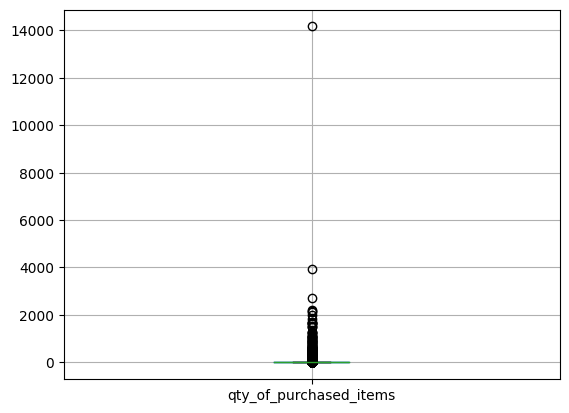

In [23]:
result.boxplot(column=['qty_of_purchased_items'])

In [24]:
to_hist = result.qty_of_purchased_items[result.qty_of_purchased_items<=15]

In [25]:
histogram(to_hist, 'Quantity of purchased items', 'Amount of users', 'Distribution of purchased items quantity <= 15')

Given this distribution, we could further investigate if the outliers are associated with campaigns, promotions or perhaps it comes with seasonal pattern and customer demography. A marketing strategy could be tailored to each segment. For retail buyers, incentives could focus on encouraging small, frequent purchases, such as through personalized recommendations or discounts on complementary products. For bulk buyers, targeted promotions might highlight volume-based discounts, early access to inventory, or rewards for high-quantity orders.

## Items Category Generating the Most Revenue 
What are the top 10 most profitable items?

In [26]:
query = f""" 
        SELECT
            product.v2ProductCategory AS category,
            SUM(totals.transactions) AS transactions,
            SUM(totals.totalTransactionRevenue)/POWER(10,6) AS total_revenue
        FROM 
            `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
            UNNEST(hits) AS hits,
            UNNEST(hits.product) AS product
        WHERE
            _TABLE_SUFFIX BETWEEN '{start}' AND '{end}'
        GROUP BY
            category
        ORDER BY
            total_revenue DESC
        LIMIT 10
        """

result = client.query(query).result().to_dataframe()

In [27]:
barh_plot(result,'category','total_revenue', 'Category With the Most Revenue')

### Forecast Demands
Let's forecast the demands for the best selling item.

In [28]:
query = f"""
        SELECT 
             product.v2ProductName AS product_name,
             COUNT(*) AS qty 
        FROM 
            `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
                UNNEST(hits) AS hits,
                UNNEST(hits.product) AS product
        WHERE 
            _TABLE_SUFFIX BETWEEN '{start}' AND '{end}'
        GROUP BY 
            product.v2ProductName
        ORDER BY 
            qty DESC
        LIMIT 10
            """
result = client.query(query).result().to_dataframe()
result.head(10)

,product_name,qty
0,Google Men's 100% Cotton Short Sleeve Hero Tee...,307311
1,22 oz YouTube Bottle Infuser,213989
2,YouTube Men's Short Sleeve Hero Tee Black,205483
3,YouTube Custom Decals,200646
4,Google Men's 100% Cotton Short Sleeve Hero Tee...,192158
5,YouTube Twill Cap,189607
6,Google Men's 100% Cotton Short Sleeve Hero Tee...,187729
7,YouTube Men's Short Sleeve Hero Tee Charcoal,185983
8,Electronics Accessory Pouch,168524
9,YouTube Wool Heather Cap Heather/Black,161851


In [29]:
print('The best selling item is : ',result.product_name.iloc[0])

The best selling item is :  Google Men's 100% Cotton Short Sleeve Hero Tee White


What are the campaigns that may influence the item's demand?

In [30]:
query = f"""
        SELECT 
            DISTINCT trafficSource.campaign
        FROM 
            `bigquery-public-data.google_analytics_sample.ga_sessions_*`
        WHERE 
            _TABLE_SUFFIX BETWEEN '{start}' AND '{end}'

            """
result = client.query(query).result().to_dataframe()
result.head(10)

,campaign
0,AW - Apparel
1,AW - Accessories
2,Data Share Promo
3,AW - Electronics
4,Data Share
5,AW - Dynamic Search Ads Whole Site
6,All Products
7,(not set)


In [31]:
query = f"""
        WITH daily_visit AS (
            SELECT 
                date,
                
                EXTRACT(DAYOFWEEK FROM PARSE_DATE('%Y%m%d', date)) AS day_of_week,
                EXTRACT(WEEK FROM PARSE_DATE('%Y%m%d', date)) AS week_of_month,
                EXTRACT(MONTH FROM PARSE_DATE('%Y%m%d', date)) AS month,
                
                COUNT(*) AS total_visitor,
            FROM 
                `bigquery-public-data.google_analytics_sample.ga_sessions_*`
            WHERE 
                _TABLE_SUFFIX BETWEEN '{start}' AND '{end}' 
            GROUP BY 
                date 
        ),
        
        daily_totals AS (
            SELECT 
                date,
                SUM(product.productQuantity) AS daily_qty,
                
                COUNTIF(trafficSource.campaign = 'AW - Dynamic Search Ads Whole Site') AS AW_Dynamic_Search_Ads_Whole_Site,
                COUNTIF(trafficSource.campaign = 'Data Share Promo') AS Data_Share_Promo,
                COUNTIF(trafficSource.campaign = 'All Products') AS All_Products,
                COUNTIF(trafficSource.campaign = 'Data Share') AS data_share,
                COUNTIF(trafficSource.campaign = 'AW - Apparel') AS AW_Apparel_campaign,
                COUNTIF(trafficSource.campaign = 'AW - Accessories') AS AW_Accessories
            
            FROM 
                `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
                UNNEST(hits) AS hits,
                UNNEST(hits.product) AS product
            WHERE 
                _TABLE_SUFFIX BETWEEN '{start}' AND '{end}' 
                AND
                product.v2ProductName = "Google Men's 100% Cotton Short Sleeve Hero Tee White"
                AND
                hits.eCommerceAction.action_type = '6'
            GROUP BY 
                date
            ORDER BY 
                date
        )
        
        SELECT 
            dv.date,
            dv.total_visitor AS total_visitor,
            dv.day_of_week,
            dv.week_of_month,
            dv.month,
            COALESCE(dt.AW_Dynamic_Search_Ads_Whole_Site,0) AS AW_Dynamic_Search_Ads_Whole_Site,
            COALESCE(dt.Data_Share_Promo,0) AS Data_Share_Promo,
            COALESCE(dt.All_Products,0) AS All_Products,
            COALESCE(dt.data_share,0) AS data_share,
            COALESCE(dt.AW_Apparel_campaign,0) AS AW_Apparel_campaign,
            COALESCE(dt.AW_Accessories,0) AS AW_Accessories,
            
            COALESCE(
            AVG(dt.daily_qty) OVER (
                ORDER BY dv.date
                ROWS BETWEEN 5 PRECEDING AND 1 PRECEDING
            ),0)
            AS _5_lagged_moving_avg,
            
            COALESCE(dt.daily_qty,0) AS qty
            
        FROM
            daily_visit AS dv
            LEFT JOIN daily_totals AS dt
                ON dv.date = dt.date
        ORDER BY 
            dv.date

        """
result = client.query(query).result().to_dataframe()
result.head(10)

,date,total_visitor,day_of_week,week_of_month,month,AW_Dynamic_Search_Ads_Whole_Site,Data_Share_Promo,All_Products,data_share,AW_Apparel_campaign,AW_Accessories,_5_lagged_moving_avg,qty
0,20160801,1711,2,31,8,0,0,0,0,0,0,0.000000,13
1,20160802,2140,3,31,8,0,0,0,0,0,0,13.000000,0
2,20160803,2890,4,31,8,0,0,0,0,0,0,13.000000,0
3,20160804,3161,5,31,8,0,0,0,0,0,0,13.000000,0
4,20160805,2702,6,31,8,10,0,0,0,0,0,13.000000,11
5,20160806,1663,7,31,8,0,0,0,0,0,0,12.000000,1
6,20160807,1622,1,32,8,0,0,0,0,0,0,6.000000,1
7,20160808,2815,2,32,8,0,0,0,0,0,0,4.333333,2
8,20160809,2851,3,32,8,0,0,0,0,0,0,3.750000,3
9,20160810,2757,4,32,8,0,0,0,0,0,0,3.600000,2


In [32]:
result.AW_Dynamic_Search_Ads_Whole_Site.value_counts()

AW_Dynamic_Search_Ads_Whole_Site
0     356
2       7
10      1
16      1
4       1
Name: count, dtype: int64

In [33]:
result.Data_Share_Promo.value_counts()

Data_Share_Promo
0    366
Name: count, dtype: int64

In [34]:
result.All_Products.value_counts()

All_Products
0    366
Name: count, dtype: int64

In [35]:
result.data_share.value_counts()

data_share
0    366
Name: count, dtype: int64

In [36]:
result.AW_Apparel_campaign.value_counts()

AW_Apparel_campaign
0    366
Name: count, dtype: int64

In [37]:
result.AW_Accessories.value_counts()

AW_Accessories
0    361
2      4
4      1
Name: count, dtype: int64

In [38]:
to_drop = ['Data_Share_Promo','All_Products','data_share','AW_Apparel_campaign']
data = result.drop(columns=to_drop)

In [39]:
# adjust column names for nixtla
data['unique_id'] = "Google Men's 100% Cotton Short Sleeve Hero Tee White"
# reformat date
result.date = pd.to_datetime(result.date, format='%Y%m%d')
data['ds']= result.date.dt.strftime('%Y-%m-%d')
data['ds'] = pd.to_datetime(data['ds'])
data = data.drop(columns=['date','qty'])
data['y'] = result.qty

In [40]:
data.head()

,total_visitor,day_of_week,week_of_month,month,AW_Dynamic_Search_Ads_Whole_Site,AW_Accessories,_5_lagged_moving_avg,unique_id,ds,y
0,1711,2,31,8,0,0,0.0,Google Men's 100% Cotton Short Sleeve Hero Tee...,2016-08-01,13
1,2140,3,31,8,0,0,13.0,Google Men's 100% Cotton Short Sleeve Hero Tee...,2016-08-02,0
2,2890,4,31,8,0,0,13.0,Google Men's 100% Cotton Short Sleeve Hero Tee...,2016-08-03,0
3,3161,5,31,8,0,0,13.0,Google Men's 100% Cotton Short Sleeve Hero Tee...,2016-08-04,0
4,2702,6,31,8,10,0,13.0,Google Men's 100% Cotton Short Sleeve Hero Tee...,2016-08-05,11


In [41]:
# split train and test
train_df = data.iloc[:-5]
test_df = data.iloc[-5:].reset_index(drop=True)
test_futr = test_df[['unique_id','ds','month','week_of_month','day_of_week']]

In [42]:
horizon = 5
models = [
          BiTCN(h = horizon,
                input_size = horizon*3,
                loss=DistributionLoss(distribution='StudentT', level=[80, 90], return_params=True),
                futr_exog_list=['day_of_week','week_of_month','month'],
                scaler_type = 'robust',
                early_stop_patience_steps=2,
                )            
                ]

nf = NeuralForecast(
    models=models,
    freq='D'
)

In [43]:
nf.fit(df=train_df, val_size=5)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [44]:
Y_hat_df = nf.predict(futr_df=test_futr)

Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/neuralforecast/core.py:214: FutureWarning:

In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.



Using the Nixtla library, the BiTCN model is trained to forecast the quantity of items bought over the next five days. The prediction range, shown by the shaded area labeled BiTCN_level_90 in the plot below, represents a 90% confidence interval. The BiTCN line indicates the median of this predicted range, while the blue line, y, shows the actual quantity of items bought. The x-axis displays dates from July 28 to August 1.

/opt/conda/lib/python3.10/site-packages/statsforecast/core.py:1407: FutureWarning:

Passing the ids as the index is deprecated. Please provide them as a column instead.



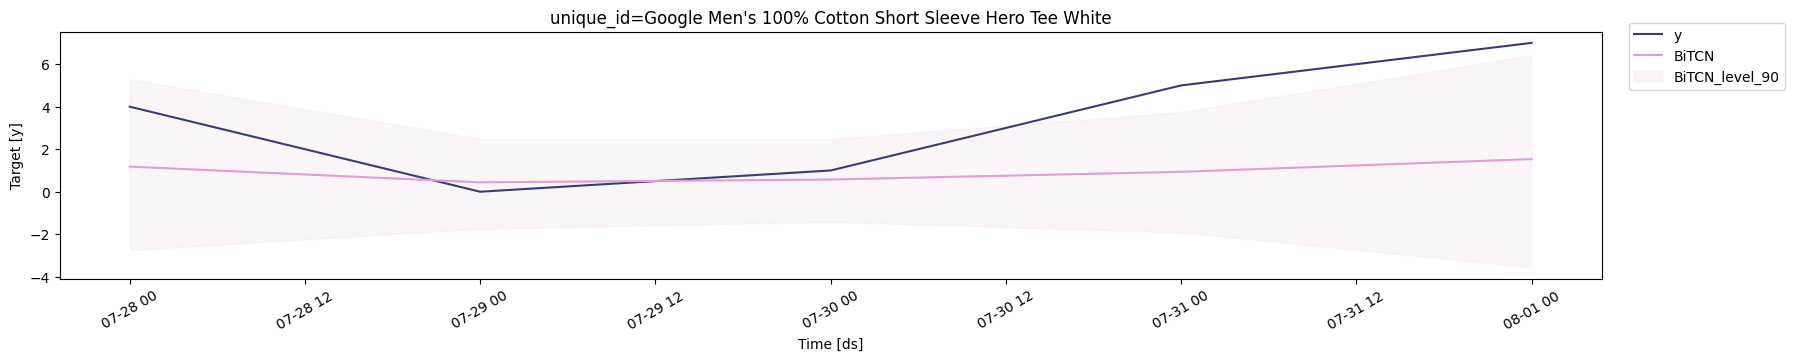

In [45]:
StatsForecast.plot(test_df, Y_hat_df, models=["BiTCN"], unique_ids=["Google Men's 100% Cotton Short Sleeve Hero Tee White"], level=[90])

## User's Geographical Location and Total Transaction
Top 10 countries to generate revenue

In [46]:
query = f"""
        SELECT
            geoNetwork.country AS country,
            SUM(totals.transactionRevenue)/POWER(10,6) AS total_transaction
            
        FROM 
            `bigquery-public-data.google_analytics_sample.ga_sessions_*`
        WHERE 
            _TABLE_SUFFIX BETWEEN '{start}' AND '{end}'
            AND 
            totals.transactionRevenue IS NOT NULL
        GROUP BY 
            country
        ORDER BY 
            total_transaction DESC
        LIMIT 10
        """
result = client.query(query).result().to_dataframe()

In [47]:
px.choropleth(result, locations="country", locationmode="country names",color="total_transaction", hover_name="country")

In [48]:
barh_plot(result,'country', 'total_transaction', 'Country and Total Transaction')

## Source of Traffic 

### Traffic Sources for First-Time Visitors

In [49]:
query = f"""
        SELECT
            channelGrouping AS traffic_source,
            COUNT(*) AS number_of_firstcomer
        FROM 
            `bigquery-public-data.google_analytics_sample.ga_sessions_*`
        WHERE 
            _TABLE_SUFFIX BETWEEN '{start}' AND '{end}'
            AND
            totals.newVisits IS NOT NULL
        GROUP BY
            channelGrouping	
        ORDER BY 
            number_of_firstcomer
        """
result = client.query(query).result().to_dataframe()

In [50]:
barh_plot(result,'traffic_source', 'number_of_firstcomer', 'Traffic Sources for First-Time Visitors')

Most first-time visitors come from organic search, which occurs when users find our website through unpaid search engine results rather than paid advertisements. This suggests that the website is effectively optimized for search engines.

In [51]:
query = f"""
        SELECT
            trafficSource.source AS traffic_source,
            COUNT(*) AS number_of_firstcomer
        FROM 
            `bigquery-public-data.google_analytics_sample.ga_sessions_*`
        WHERE 
            _TABLE_SUFFIX BETWEEN '{start}' AND '{end}'
            AND
            totals.newVisits IS NOT NULL
        GROUP BY
            traffic_source
        ORDER BY 
            number_of_firstcomer DESC
        LIMIT 10
        """
result = client.query(query).result().to_dataframe()

In [52]:
barh_plot(result,'traffic_source', 'number_of_firstcomer', 'Top 10 Traffic Sources Domain for First-Time Visitors')

The top social platform that brings the most First-Time Visitors is Youtube.

### For Returning Visitors

In [53]:
query = f"""
        SELECT
            trafficSource.source AS traffic_source,
            COUNT(*) AS number_of_returning_visitors
        FROM 
            `bigquery-public-data.google_analytics_sample.ga_sessions_*`
        WHERE 
            _TABLE_SUFFIX BETWEEN '{start}' AND '{end}'
            AND
            totals.newVisits IS NULL
        GROUP BY
            traffic_source
        ORDER BY 
            number_of_returning_visitors DESC
        LIMIT 10
        """
result = client.query(query).result().to_dataframe()

In [54]:
barh_plot(result,'traffic_source', 'number_of_returning_visitors', 'Source of Traffic Domain for Returning Visitors')

For returning visitors, the most common way they access our website is through direct traffic. This is primarily due to users who have bookmarked our site or entered the URL directly into their browser.

## The Most Viewed Page, and Their Respective Bounce Rate
What are the top 10 most viewed page?

In [55]:
# What's the most viewed page?
query = f"""
        SELECT 
            hits.page.pagePath AS page,
            COUNT(*) AS number_of_views,
            ROUND((SUM(totals.bounces)/COUNT(*))*100, 2) AS bounce_rate
        FROM 
            `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
            UNNEST(hits) AS hits
        WHERE
            _TABLE_SUFFIX BETWEEN '{start}' AND '{end}'
            AND
            hits.type = 'PAGE'
        GROUP BY 
            page
        ORDER BY
            number_of_views DESC
        LIMIT 10
        """
result = client.query(query).result().to_dataframe()

In [56]:
grouped_bar(result.page,result.number_of_views,result.bounce_rate,'Page Views','Bounce Rate (%)','Top 10 Viewed Page and Their Bounce Rate')

## The Most Successful Campaigns
Which campaigns attract the most visitors?

In [57]:
query = f"""
        SELECT
            trafficSource.campaign AS campaign,
            COUNT(*) AS number_of_visitors,
            SUM(totals.transactionRevenue)/POWER(10,6) AS total_transaction
            
        FROM 
            `bigquery-public-data.google_analytics_sample.ga_sessions_*`
        WHERE 
            _TABLE_SUFFIX BETWEEN '{start}' AND '{end}'
            AND
            trafficSource.campaign != '(not set)'
        GROUP BY
            campaign
        ORDER BY 
            number_of_visitors DESC
        """
result = client.query(query).result().to_dataframe()

In [58]:
grouped_bar(result.campaign,result.number_of_visitors,result.total_transaction,'Number of Visitors','Total Revenue','Top Accessed Campaigns with Revenue Comparison')

The Data Share Promo is the top campaign in terms of visitor traffic, but it has generated the least revenue. In contrast, the AW-Accessories campaign, which attracts the fewest customers, has generated the highest revenue. This indicates that while the Data Share Promo is effective at drawing in a large audience, it may not be converting visitors into paying customers as effectively as AW-Accessories. The latter campaign, despite its lower traffic, likely targets a more engaged audience willing to make purchases.

## Sessions by Device and Browser
Are there compatibility issues?

### Browser

In [59]:
query = f"""
        SELECT 
            device.Browser AS browser,
            COUNT(*) AS sessions,
            (SUM(totals.bounces)/COUNT(*))*100 AS bounce_rate
        FROM 
            `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
            UNNEST(hits) AS hits
        WHERE
            _TABLE_SUFFIX BETWEEN '{start}' AND '{end}'
        GROUP BY 
            browser
        ORDER BY 
            sessions DESC
        LIMIT 10
        """

result = client.query(query).result().to_dataframe()

In [60]:
grouped_bar(result.browser,result.sessions,result.bounce_rate,'Total Sessions','Bounce Rate(%)','Top Browsers and Their Bounce Rates')

Chrome is the most commonly used browser among visitors and has the lowest bounce rate, while other browsers are used significantly less and exhibit much higher bounce rates. This indicates that the website may not be fully optimized for browsers other than Chrome.

## Engaged Vs Non-Engaged Visitors
Create PCA visualization to see clusters of visitors who are engaged and those who are not.

In [61]:
query = f"""
        SELECT
            COALESCE(totals.hits, 0) AS hits,
            COALESCE(totals.pageviews, 0) AS pageviews,
            COALESCE(totals.timeOnSite, 0) AS timeOnSite,
            CASE
                WHEN totals.transactions > 0 THEN 1
                ELSE 0
            END AS transaction
        FROM 
            `bigquery-public-data.google_analytics_sample.ga_sessions_*`
        WHERE 
            _TABLE_SUFFIX BETWEEN '{start}' AND '{end}'
            AND
            totals.bounces IS NULL
        """
result = client.query(query).result().to_dataframe()

In [62]:
X = result[['hits','pageviews','timeOnSite']]
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

pca = PCA(n_components=2)
components = pca.fit_transform(X_normalized)

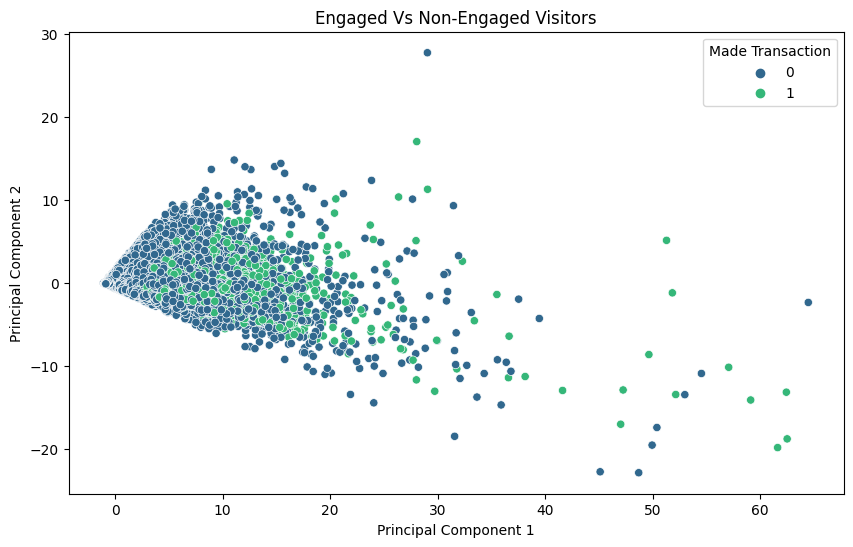

In [63]:
pca_df = pd.DataFrame(data=components, columns=['PC1', 'PC2'])
pca_df['category'] = result['transaction']  # Optional, for coloring in the plot

# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='category', data=pca_df, palette='viridis')
plt.title('Engaged Vs Non-Engaged Visitors')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Made Transaction')
plt.show()

In [64]:
# For the customers that do not bounced, how many returning visits do they made?
query = """
    WITH number_of_visits AS(
        SELECT 
            fullVisitorId, COUNT(*) AS number_of_visits
        FROM 
            `bigquery-public-data.google_analytics_sample.ga_sessions_*`
        WHERE 
            totals.bounces IS NULL
            AND
            _TABLE_SUFFIX BETWEEN '20160801' AND '20160831'
        GROUP 
            BY fullVisitorId)
    SELECT 
        nov.number_of_visits, COUNT(*) AS amount_of_user
    FROM 
        number_of_visits AS nov
    GROUP BY 
        nov.number_of_visits
    ORDER BY 
        amount_of_user
        
        """
result = client.query(query).result().to_dataframe()

In [65]:
barh_plot(result, 'number_of_visits', 'amount_of_user','For the customers that do not bounced, how many visits do they made?')